## Contents:
* [Load Data](#load-data)
* [Observations](#obs)
* [Target Item and Users](#target-item-user)
* [Create Fake Profile](#create-fake-data)
* [Evaluation](#eval-attack)
 * [Prediction Shift](#pred-shift)
 * [Hit Ratio](#hit-ratio)
 




In [512]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

In [3]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

## Load Data <a class="anchor" id="load-data"></a>

In [700]:
schema_ratings = StructType([
    StructField("user_id", IntegerType(), False),
    StructField("item_id", IntegerType(), False),
    StructField("rating", IntegerType(), False),
    StructField("timestamp", IntegerType(), False)])

schema_items = StructType([
    StructField("item_id", IntegerType(), False),
    StructField("movie", StringType(), False),
    StructField("release_date", StringType(), False),
    StructField("v_release_date", StringType(), False),
    StructField("imdb_url", StringType(), False),
    StructField("unknown", StringType(), False),
    StructField("action", StringType(), False),
    StructField("adventure", StringType(), False),
    StructField("animation", StringType(), False),
    StructField("childrens", StringType(), False),
    StructField("comedy", StringType(), False),
    StructField("crime", StringType(), False),
    StructField("documentary", StringType(), False),
    StructField("drama", StringType(), False),
    StructField("fantasy", StringType(), False),
])

training = spark.read.option("sep", "\t").csv("../data/MovieLens.training", header=False, schema=schema_ratings)
test = spark.read.option("sep", "\t").csv("../data/MovieLens.test", header=False, schema=schema_ratings)
items = spark.read.option("sep", "|").csv("../data/MovieLens.item", header=False, schema=schema_items)

In [514]:
trainDf = training.toPandas()
testDf = test.toPandas()
num_users, num_items = len(trainDf.user_id.unique()), len(trainDf.item_id.unique())
max_uid, max_iid = trainDf.user_id.unique().max(), trainDf.item_id.unique().max()
print(f'num_users: {num_users} num_items : {num_items}')
print(f'max_user_id: ', max_uid, " max_item_id: ", max_iid)

num_users: 943 num_items : 1650
max_user_id:  943  max_item_id:  1682


In [670]:
# - Get ratings mean and rating std
stdDf = trainDf.groupby('item_id', as_index=False).agg(rating_mean= ('rating', 'mean'), rating_std= ('rating', 'std'), 
                                  rating_count = ('rating', 'count'))
item_mean = dict(zip(stdDf.item_id,stdDf.rating_mean))
item_std = dict(zip(stdDf.item_id,stdDf.rating_std))
rating_mean, rating_std = trainDf.rating.mean(), trainDf.rating.std()
print(f'rating_mean: {rating_mean} rating_std: {rating_std}')

rating_mean: 3.52835 rating_std: 1.118564668374818


array([[<AxesSubplot:title={'center':'rating_count'}>]], dtype=object)

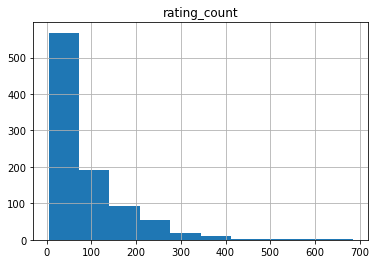

In [682]:
# - count of ratings per user
userRatingDf = trainDf.groupby('user_id', as_index=False).agg(rating_count= ('rating', 'count')).sort_values(
    'rating_count', ascending=False)
hist = userRatingDf.hist(column='rating_count', bins=10)
hist

In [695]:
userRatingDf[userRatingDf.user_id.isin([88,440, 782])]

,user_id,rating_count
781,782,232
439,440,48
87,88,11


array([[<AxesSubplot:title={'center':'rating_mean'}>]], dtype=object)

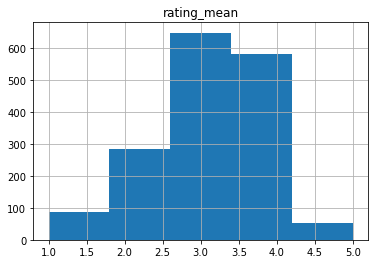

In [687]:
# - avg rating of items
itemRatingDf = trainDf.groupby('item_id', as_index=False).agg(rating_mean= ('rating', 'mean')).sort_values(
    'rating_mean', ascending=False)
hist = itemRatingDf.hist(column='rating_mean', bins=5)
hist

In [694]:
itemWithratingAbove4 = itemRatingDf[itemRatingDf.rating_mean > 4].item_id.to_list()
longTailItems = itemRatingDf[itemRatingDf.rating_mean < 1.5].item_id.to_list()
print(f'itemWithratingAbove4: {itemWithratingAbove4}')
print(f'longTailItems: {longTailItems}')
#print(f'longTailItems: {itemRatingDf[itemRatingDf.item_id == 1191]}')
trainDf[trainDf.item_id == 1191]

itemWithratingAbove4: [1189, 1653, 1599, 1500, 1467, 1201, 1122, 1293, 1449, 1367, 408, 169, 850, 1594, 1642, 318, 483, 64, 12, 50, 603, 114, 1191, 119, 1639, 1125, 513, 178, 357, 480, 427, 98, 963, 134, 313, 488, 966, 251, 127, 1396, 1064, 479, 174, 285, 515, 272, 657, 474, 641, 199, 867, 1466, 320, 172, 524, 173, 484, 187, 302, 1142, 511, 1524, 316, 191, 528, 89, 493, 487, 223, 185, 166, 22, 190, 192, 1251, 170, 1131, 647, 478, 498, 489, 100, 48, 633, 520, 505, 315, 165, 496, 923, 606, 661, 79, 23, 490, 654, 124, 180, 30, 651, 45, 197, 589, 168, 1039, 611, 601, 430, 194, 132, 613, 615, 607, 83, 136, 659, 527, 519, 213, 1007, 656, 694, 494, 189, 60, 56, 181, 198, 87, 205]
longTailItems: [1420, 1162, 777, 442, 1287, 424, 1246, 438, 1661, 1350, 1654, 1678, 1354, 1359, 1325, 1366, 1329, 1334, 1671, 1339, 1363, 1340, 1659, 1352, 1349, 1341, 1567, 1374, 1566, 1587, 1307, 1584, 1583, 1581, 1580, 1579, 1577, 1564, 1576, 1575, 1574, 1572, 1571, 1570, 1569, 1308, 1306, 858, 1621, 784, 1546, 12

,user_id,item_id,rating,timestamp
4932,88,1191,5,891038103
29714,440,1191,5,891550404
63675,782,1191,3,891498558


## Observations <a class="anchor" id="obs"></a>
* In test set, there were not any target user, target item pair..  Hence when we try to check prediction shift for target user and target item pair we get nothing!!
* Item which is least popular as in has less ratings like 3 rating but the 3 rating has a avg of 4.3 in such cases the hit ratio for these items is higher. This was because one of the user among 2 had rated around 220 items.

## Selected Items <a class="anchor" id="sel-items"></a>

In [668]:
NUM_SEL_ITEMS = 3
NUM_FILLER_ITEMS = 90

In [516]:
# - Create popular selected item list
item_ratings = dict(trainDf.groupby('item_id').size())
item_pop = [0] * (max_iid + 1)

for item_id in item_ratings.keys():
    item_pop[item_id] = item_ratings[item_id]
    
items_sorted = np.array(item_pop).argsort()[::-1]
selected_items = items_sorted[:NUM_SEL_ITEMS]
print("selected_items: ", selected_items)

selected_items:  [ 50 181 258]


In [517]:
trainDf.groupby('item_id', as_index=False).agg(
    rating_sum= ('rating', 'count')).sort_values('rating_sum', ascending=False).head(NUM_SEL_ITEMS)

,item_id,rating_sum
49,50,484
180,181,422
257,258,402


## Target Item and Users <a class="anchor" id="target-item-user"></a>

In [671]:
# - Select target item
target_items = [j for i in range(8, 10) for j in
                    items_sorted[i * len(items_sorted) // 10:(i * len(items_sorted) // 10) + 2]][::-1]
target_items = list(np.random.choice([i for i in range(len(item_pop)) if item_pop[i] > 3 and item_pop[i] > 9 ], 
                                     3, replace=False)) + target_items


print('target_items before filtering with test :', target_items)
target_items = list(testDf[testDf.item_id.isin(target_items)].item_id.unique())
#target_items += [1191]

# -- HARD CODING VALUES HERE 
target_items = [868, 1162, 927, 1521, 1301, 1191]
print('target_items:', target_items)
print('target_items rating count: ', [(i, item_pop[i]) for i in target_items])


target_items before filtering with test : [252, 670, 893, 1564, 1647, 1301, 927]
target_items: [868, 1162, 927, 1521, 1301, 1191]
target_items rating count:  [(868, 3), (1162, 3), (927, 4), (1521, 3), (1301, 4), (1191, 3)]


In [672]:
# - create target users    
users_rated_target = set(trainDf[trainDf.item_id.isin(target_items)].user_id.values)
# - Users who have not rated target item
data_tmp = trainDf[~trainDf.user_id.isin(users_rated_target)].copy()
#data_tmp = data_tmp[data_tmp.rating >= threshold]

# - Users who have not rated target item and have rated selected_items
target_users = data_tmp[data_tmp.item_id.isin(selected_items)].groupby('user_id').size()


print("target_users[(target_users == selected_num)].shape[0]: ", 
       target_users[(target_users == NUM_SEL_ITEMS)].shape[0])
target_users = sorted(target_users[(target_users == NUM_SEL_ITEMS)].index)
target_users
print("target_users: ", len(target_users))

target_users[(target_users == selected_num)].shape[0]:  190
target_users:  190


## Fake profile creation <a class="anchor" id="create-fake-data"></a>

In [704]:
# - get filler items
from random import randrange

class FakeProfile(object): 
    MAX_RATING = 5
    
    def __init__(self, target_items, 
                 filler_item_count = 70):
        self.target_items  = target_items
        self.filler_item_count = filler_item_count
        self.selected_items = {}
        self.filler_items = {}
        
    def setSelectedItems(self, selectedItems):
        #selectedItems = freqRatedItems[np.random.choice(len(freqRatedItems), size=self.selected_items_count, replace=False)]
        for item in selectedItems:
            self.selected_items[item] = self.MAX_RATING
    
    def fillerItems(self, selectedItems):
        targetSelItems = list(self.target_items)
        targetSelItems.extend(selectedItems)
        #print(targetSelItems)
        fillers_candidates = list(set(trainDf.item_id.unique()) - set(targetSelItems) )
        fillers = np.random.choice(fillers_candidates, size=self.filler_item_count, replace=False)
        ratings = np.round(np.random.normal(loc=rating_mean, scale=rating_std, size=self.filler_item_count), 1)
        for item, rating in zip(fillers, ratings):
            self.filler_items[item] = rating
                
    def create(self, selectedItems):
        self.setSelectedItems(selectedItems)
        self.fillerItems(selectedItems)
        
    def print(self):
        print(f'target_item : {self.target_items}')
        print(f'selected_items : {self.selected_items}')
        print(f'filler_items : {self.filler_items}')
        print("\n")
        
    def getAllItemRatings(self):
        itemRatings = [(item, self.MAX_RATING) for item in self.target_items]
        for item in self.selected_items:
            itemRatings.append((item, self.selected_items[item]))
        for item in self.filler_items:
            itemRatings.append((item, self.filler_items[item]))
        return itemRatings
    
def createProfiles(target_items, selected_items, n):
    fake_profiles = []
    for _ in range(n):
        fp = FakeProfile(target_items)
        fp.create(selected_items)
        fake_profiles.append(fp)
    
    '''
    # - Uncomment to print
    for fp in fake_profiles:
        fp.print()
    '''
    return fake_profiles
 
def createProfilesAsDf(target_items, selected_items, n):
    fake_profiles = createProfiles(target_items, selected_items, n)
    userId = 1100
    timestamp = 874965758
    fakeRatingsdata = {'userId': [], 'item_id': [], 'ratings': [], 'timestamp': []}
    for fp in fake_profiles:
        userId += 1
        itemRatings = fp.getAllItemRatings()
        for itemRatingPair in itemRatings:
            fakeRatingsdata['userId'].append(userId)
            fakeRatingsdata['item_id'].append(itemRatingPair[0])
            fakeRatingsdata['ratings'].append(itemRatingPair[1])
            fakeRatingsdata['timestamp'].append(timestamp)

    columnsZipped = zip(fakeRatingsdata['userId'], fakeRatingsdata['item_id'],
                       fakeRatingsdata['ratings'], fakeRatingsdata['timestamp'])
    fakeProfileDf = pd.DataFrame(list(columnsZipped),
                   columns =['user_id', 'item_id', 'rating', 'timestamp'])
    return fakeProfileDf

In [705]:
NUM_FAKE_USERS = 50
attackDataDf = createProfilesAsDf(target_items, selected_items, NUM_FAKE_USERS)

In [658]:
attackDataDf

,user_id,item_id,rating,timestamp
0,1101,868,5.0,874965758
1,1101,1162,5.0,874965758
2,1101,927,5.0,874965758
3,1101,1521,5.0,874965758
4,1101,1301,5.0,874965758
...,...,...,...,...
3945,1150,12,1.1,874965758
3946,1150,1666,4.1,874965758
3947,1150,1066,3.5,874965758
3948,1150,881,3.4,874965758


In [639]:
attackTrainData = pd.concat([trainDf, attackDataDf]).sort_values(by=['user_id', 'item_id'])
attackTrainData

,user_id,item_id,rating,timestamp
0,1,1,5.0,874965758
1,1,2,3.0,876893171
2,1,3,4.0,878542960
3,1,4,3.0,876893119
4,1,5,3.0,889751712
...,...,...,...,...
3917,1150,1566,5.4,874965758
3946,1150,1633,3.9,874965758
3921,1150,1637,2.9,874965758
3916,1150,1679,5.1,874965758


## Evaluation <a class="anchor" id="eval-attack"></a>

### RMSE <a class="anchor" id="rmse"></a>

#### Model before attack data

In [525]:
# 0.1
als = ALS(maxIter=10, rank=100, regParam=0.1, userCol="user_id", itemCol="item_id", ratingCol="rating", coldStartStrategy="drop")
model = als.fit(training)
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
rmse

0.9283872090543989

In [526]:
userRecs = model.recommendForAllUsers(10)
userRecs = userRecs.toPandas()

In [527]:
count = 0
for index, row in userRecs.iterrows():
    recommendations = [r['item_id'] for r in row['recommendations']]
    if target_item in recommendations:
        print(row['user_id'], recommendations)
        count += 1
print(f'Total users with {target_item}: {count}')

Total users with 243: 0


#### Model with train data + attack data

In [640]:
# 0.1
attackDF = spark.createDataFrame(attackTrainData)
als_atk = ALS(maxIter=10, rank=100, regParam=0.1, userCol="user_id", itemCol="item_id", ratingCol="rating", coldStartStrategy="drop")
model_atk = als_atk.fit(attackDF)
predictions_atk = model_atk.transform(test)
evaluator_atk = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse_atk = evaluator_atk.evaluate(predictions_atk)
rmse_atk

0.9258617814201447

### Calculate prediction shift <a class="anchor" id="pred-shift"></a>

In [641]:
predAtk = predictions_atk.toPandas()
pred = predictions.toPandas()
targetUsersTest = testDf[testDf.user_id.isin(target_users)]
numTargetUsersInTest = len(targetUsersTest.user_id.unique())
print(f'Number of target users in test: {numTargetUsersInTest}')

Number of target users in test: 40


In [642]:
pred[pred.user_id.isin(target_users)]

,user_id,item_id,rating,timestamp,prediction
4,222,148,2,881061164,2.995661
10,328,148,3,885048638,3.160234
14,447,148,4,878854729,3.034730
38,313,148,2,891031979,2.723193
51,354,463,4,891217575,3.740919
...,...,...,...,...,...
19903,301,89,2,882076046,3.966234
19916,151,89,5,879524491,4.600976
19928,222,401,2,878184422,1.868581
19934,301,401,4,882078040,2.969263


<h4>Prediction shift across targetted users</h4>

In [643]:
predAttackTargetUser = predAtk[predAtk.user_id.isin(target_users)].sort_values(['user_id', 'item_id']).prediction
predTargetUser = pred[pred.user_id.isin(target_users)].sort_values(['user_id', 'item_id']).prediction

np.sum(predAttackTargetUser - predTargetUser)/numTargetUsersInTest

0.07029163837432861

In [667]:
predAttackTargetUser = predAtk[predAtk.user_id.isin(target_users)].sort_values(['user_id', 'item_id']).prediction

10670    3.335442
1359     4.217900
15512    3.836432
17463    4.256400
10084    3.773332
           ...   
4786     3.831770
4068     3.526086
15934    3.757811
7697     2.823140
19453    2.937871
Name: prediction, Length: 2228, dtype: float32

<h4>Prediction across all users</h4>

In [644]:
predAfterAttack = predAtk.sort_values(['user_id', 'item_id']).prediction
predBeforeAttack = pred.sort_values(['user_id', 'item_id']).prediction

np.sum(predAfterAttack - predBeforeAttack)/len(testDf.user_id.unique())

0.3404002137693185

### Calculate Hit Ratio <a class="anchor" id="hit-ratio"></a>

In [645]:
testDf[testDf.item_id.isin(target_items)].item_id.unique().size

5

In [646]:
def getTopNRecommendations(model, testUserIds, n=10):
    recommendations = {}
    userRecs = model.recommendForAllUsers(10)
    userRecs = userRecs.toPandas()
    
    for index, row in userRecs.iterrows():
        if row['user_id'] in testUserIds:
            userRec = [r['item_id'] for r in row['recommendations']]
            recommendations[row['user_id']] = userRec 
    return recommendations

def filterRecsByTargetItem(recommendations, targetItems):
    recWithTargetItems = {}
    for user_id in recommendations.keys():
        topNRec = recommendations[user_id]
        is_target_item_present = any(item in topNRec for item in targetItems)
        if is_target_item_present:
            recWithTargetItems[user_id] = topNRec
            print(user_id, topNRec)
    
    return recWithTargetItems

In [647]:
testUserIds = testDf.user_id.unique()
topNRecAllUsersAtk = getTopNRecommendations(model_atk, testUserIds)
topNRecAllUsersWithTargets = filterRecsByTargetItem(topNRecAllUsersAtk, target_items)
print(f'Number of users with targets: {len(topNRecAllUsersWithTargets)}')

137 [50, 174, 181, 96, 1269, 868, 1301, 1515, 1191, 79]
300 [1515, 868, 1313, 1191, 1301, 927, 1124, 1521, 881, 922]
332 [169, 868, 313, 50, 318, 1301, 1191, 174, 64, 927]
388 [96, 1269, 1301, 927, 1191, 868, 50, 79, 174, 98]
372 [868, 1482, 1124, 1301, 1449, 1191, 927, 1220, 98, 1063]
319 [318, 316, 272, 1662, 313, 64, 246, 133, 1301, 1191]
355 [1515, 1662, 1301, 1191, 927, 1449, 50, 868, 313, 318]
348 [313, 927, 1301, 1191, 868, 126, 22, 1449, 318, 50]
164 [272, 318, 1443, 1449, 313, 927, 22, 1191, 868, 126]
169 [258, 64, 190, 313, 1137, 408, 50, 927, 1301, 1191]
283 [50, 169, 483, 12, 114, 1191, 64, 168, 172, 1301]
57 [64, 50, 313, 318, 181, 169, 174, 1191, 963, 927]
279 [1491, 1206, 502, 169, 868, 1191, 189, 862, 927, 1301]
257 [318, 315, 1449, 316, 251, 19, 285, 14, 1191, 515]
309 [1515, 258, 1301, 868, 1191, 331, 927, 1269, 1293, 1521]
262 [1449, 190, 131, 483, 699, 1191, 251, 318, 486, 813]
127 [230, 271, 228, 222, 901, 1269, 343, 258, 1521, 927]
88 [1515, 1449, 1191, 921, 1558,

In [648]:
topNRecAllUsersB4 = getTopNRecommendations(model, testUserIds)
topNRecAllUsersWithTargetsB4 = filterRecsByTargetItem(topNRecAllUsersB4, target_items)
print(f'Number of users with targets before attack: {len(topNRecAllUsersWithTargetsB4)}')

440 [190, 1449, 302, 1191, 408, 12, 1194, 513, 64, 242]
88 [1191, 1449, 286, 745, 311, 1466, 251, 537, 19, 921]
Number of users with targets before attack: 2


In [660]:
def getHitRatioPerItem(topNRecAllUsers, targetItems):
    hitRatioAllItems = {}
    
    for item in targetItems:
        usersWithItem = 0
        for user in topNRecAllUsers.keys():
            if item in topNRecAllUsers[user]:
                usersWithItem += 1
        hitRatio_i = usersWithItem/(len(topNRecAllUsers.keys()) * 1.0)
        hitRatioAllItems[item] = hitRatio_i
                                    
    return hitRatioAllItems 

def getAvgHitRatio(hitRatioPerItem):
    hitRatioPerItem = getHitRatioPerItem(topNRecAllUsersAtk, target_items)

    sumHitRatio = 0
    for hitRatio_i in hitRatioPerItem.values():
        sumHitRatio += hitRatio_i 
    return sumHitRatio/(len(hitRatioPerItem.keys()) * 1.0)

In [664]:
hitRatioPerItem = getHitRatioPerItem(topNRecAllUsersAtk, target_items)
print("hitRatioPerItem: ", hitRatioPerItem)
avgHitRatio = getAvgHitRatio(hitRatioPerItem)
print("\navgHitRatio after attack: ", avgHitRatio)

hitRatioPerItem:  {868: 0.054466230936819175, 1162: 0.0, 927: 0.0718954248366013, 1521: 0.017429193899782137, 1301: 0.08278867102396514, 1191: 0.10239651416122005}

avgHitRatio after attack:  0.05482933914306464


## Random Analysis <a class="anchor" id="rand-analysis"></a>

### Choose items which have less rating (long tail items) as target items. 
* Two cases 5 items which has less rating count but high avg rating value 
* Two cases 5 items which has less rating count but low avg rating value  

### Choose target items which have rating avg less than 2 randomly

### Choose target items which have average rating and average popularity 

### Metrics using single target item randomly (with rating below 1 and rating between 1 - 2 and 3), 10 target items